## Data

This database contains 14 physical attributes based on physical testing of a patient. Blood samples are taken and the patient also conducts a brief exercise test. The "goal" field refers to the presence of heart disease in the patient. It is integer (0 for no presence, 1 for presence). In general, to confirm 100% if a patient has heart disease can be quite an invasive process, so if we can create a model that accurately predicts the likelihood of heart disease, we can help avoid expensive and invasive procedures.

Content

Attribute Information:

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
* target:0 for no presence of heart disease, 1 for presence of heart disease

Original Source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Creators:

Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

In [1]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize


In [141]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [142]:
df = pd.merge(X, y, left_index=True, right_index=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Exploratory Data Analysis and Visualization
---
- Perform EDA and explain each graph

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [144]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [145]:
df['num'].value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

### Visualization Tasks

**TASK: Create a bar plot that shows the total counts per target value.**

Text(0, 0.5, 'Count')

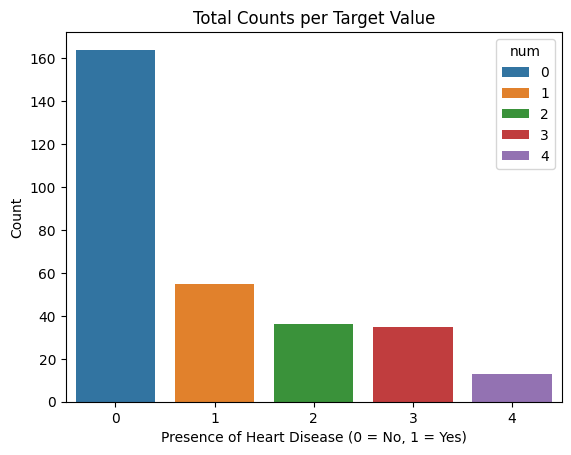

In [146]:
palette = {0: '#1f77b4', 
           1: '#ff7f0e',  
           2: '#2ca02c', 
           3: '#d62728', 
           4: '#9467bd'  
          }
sns.countplot(x='num', hue='num', data=df, palette=palette)
plt.title('Total Counts per Target Value')
plt.xlabel('Presence of Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')

**TASK: Create a pairplot that displays the relationships between the following columns:**

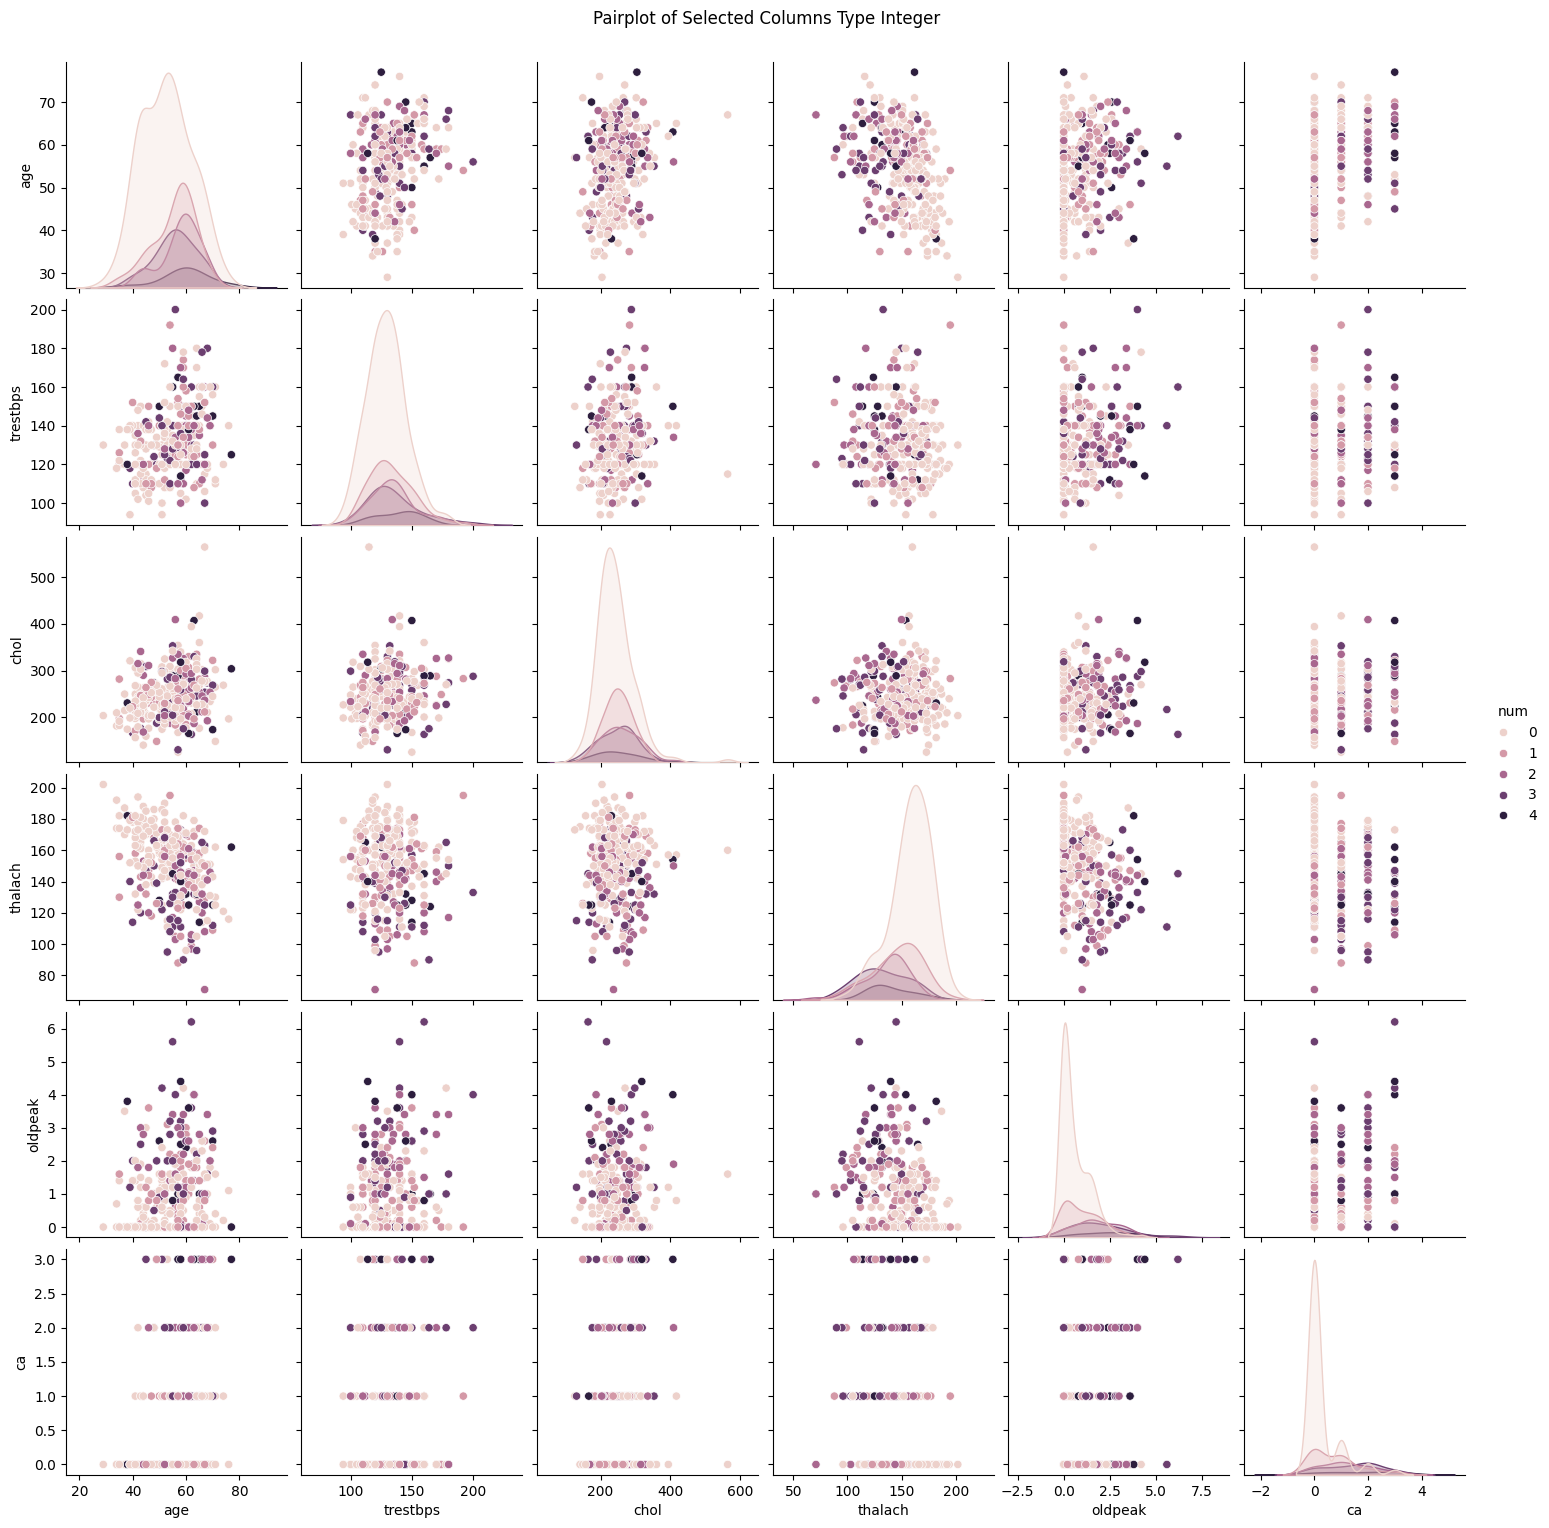

In [147]:
column = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'num']

sns.pairplot(df[column],hue='num')
plt.suptitle('Pairplot of Selected Columns Type Integer', y=1.02)
plt.show()

**TASK: Create a heatmap that displays the correlation between all the columns.**

Text(0.5, 1.0, 'Correlation Heatmap')

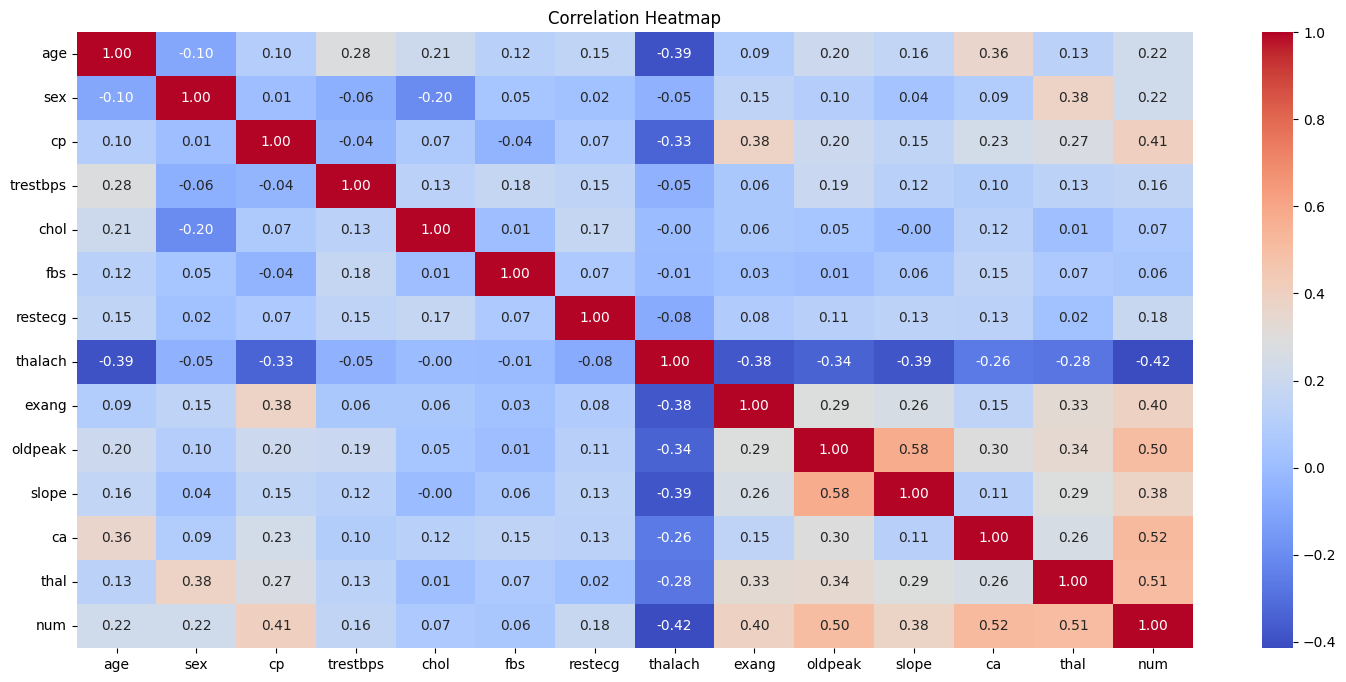

In [148]:
plt.figure(figsize=(18, 8))

sns.heatmap(df.corr(),annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

# Modeling Task

## Train | Test Split and Scaling

**TASK: Separate the features from the labels into 2 objects, X and y.**

In [149]:
X = df.drop('num',axis=1)
y = df['num']

**TASK: Perform a train test split on the data, with the test size of 5% and a random_state of 0.**

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

**TASK: Create a StandardScaler object and normalize the X train and test set feature data.**

In [151]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

nan_indices = np.isnan(scaled_X_train).any(axis=1)

X_train_scaled_clean = scaled_X_train[~nan_indices]
y_train_clean = y_train[~nan_indices]

## Logistic Regression Model

**TASK: Create a Logistic Regression model and use Cross-Validation to find a well-performing C value for the hyper-parameter search. You have two options here, use *LogisticRegressionCV* OR use a combination of *LogisticRegression* and *GridSearchCV*. The choice is up to you.**

In [152]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(scaled_X_train)

lr_cv = LogisticRegressionCV(Cs=10, cv=5, random_state=42, max_iter=1000)
lr_cv.fit(X_train_scaled_clean, y_train_clean)

c_val = lr_cv.C_[0]

**TASK: Report back your search's optimal parameters, specifically the C value.** 

*Note: You may get a different value than what is shown here depending on how you conducted your search.*

In [153]:
best_C = lr_cv.C_[0]
print("Optimal C value:", best_C)

Optimal C value: 0.3593813663804626


### Coeffecients

**TASK: Report back the model's coefficients.**

In [154]:
coefficients = lr_cv.coef_

print("Model Coefficients:")
for feature, coef in zip(X.columns, coefficients[0]):
    print(f"{feature}: {coef}")

Model Coefficients:
age: 0.009594707729304808
sex: -0.3005907477300194
cp: -0.46766322453949494
trestbps: -0.29839640249671706
chol: -0.25782929071236466
fbs: 0.23784053756284537
restecg: -0.15007744842024792
thalach: 0.27382032352964103
exang: -0.32961356790462143
oldpeak: -0.4068640309331305
slope: -0.35384482864836686
ca: -0.9829579151294853
thal: -0.6983814433241016


**Task: Create a visualization of the coefficients.**

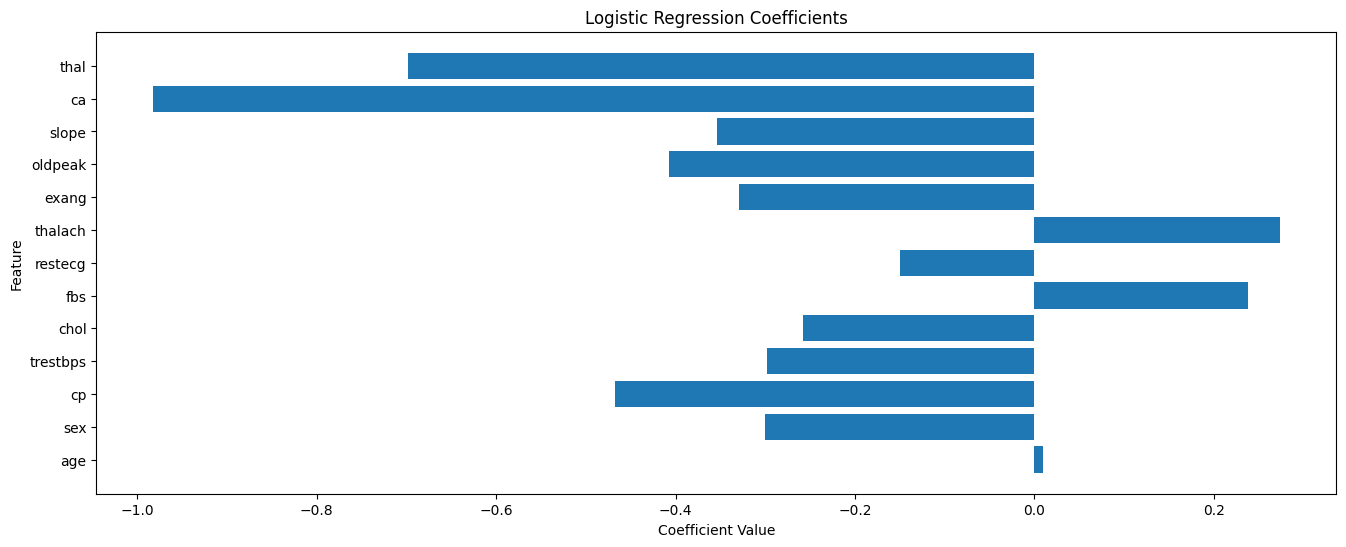

In [155]:
coefficients = lr_cv.coef_[0]

feature_names = X.columns

plt.figure(figsize=(16, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.title('Logistic Regression Coefficients')
plt.show()

---------

## Model Performance Evaluation

**TASK: Evaluate your model on the remaining 5% of the data, the test set.**

**TASK: Create the following evaluations:**
* Confusion Matrix Array
* Confusion Matrix Plot
* Classification Report

In [156]:
y_pred = lr_cv.predict(scaled_X_test)
accuracy_score(y_test,y_pred)

0.375

In [157]:
confusion_matrix(y_test,y_pred)

array([[5, 0, 2, 0],
       [2, 1, 1, 0],
       [2, 0, 0, 1],
       [0, 1, 1, 0]], dtype=int64)

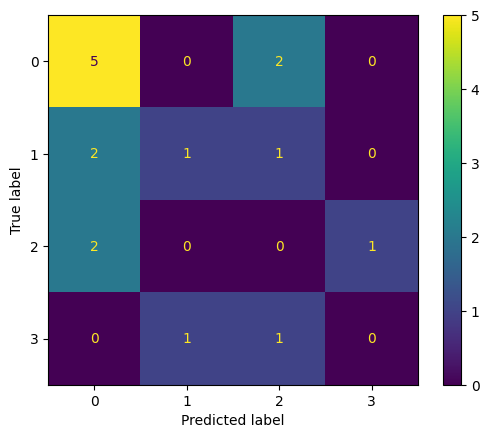

In [158]:
ConfusionMatrixDisplay.from_estimator(lr_cv,scaled_X_test,y_test)

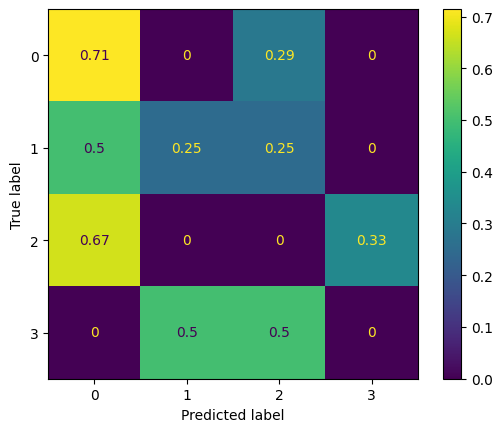

In [159]:
ConfusionMatrixDisplay.from_estimator(lr_cv,scaled_X_test,y_test,normalize='true')

In [160]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.71      0.63         7
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.38        16
   macro avg       0.26      0.24      0.24        16
weighted avg       0.37      0.38      0.36        16



### Performance Curves

**TASK: Create both the precision recall curve and the ROC Curve.**

**Precision Recall Curve**

In [161]:
def plot_multiclass_prc(clf, X_test, y_test, n_classes, figsize=(8, 6)):
    classes = range(n_classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    precision = dict()
    recall = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], clf.predict_proba(X_test)[:, i])

    plt.figure(figsize=figsize)
    for i in range(len(classes)):
        plt.plot(recall[i], precision[i], label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multiclass Classification')
    plt.legend(loc='best')
    plt.show()

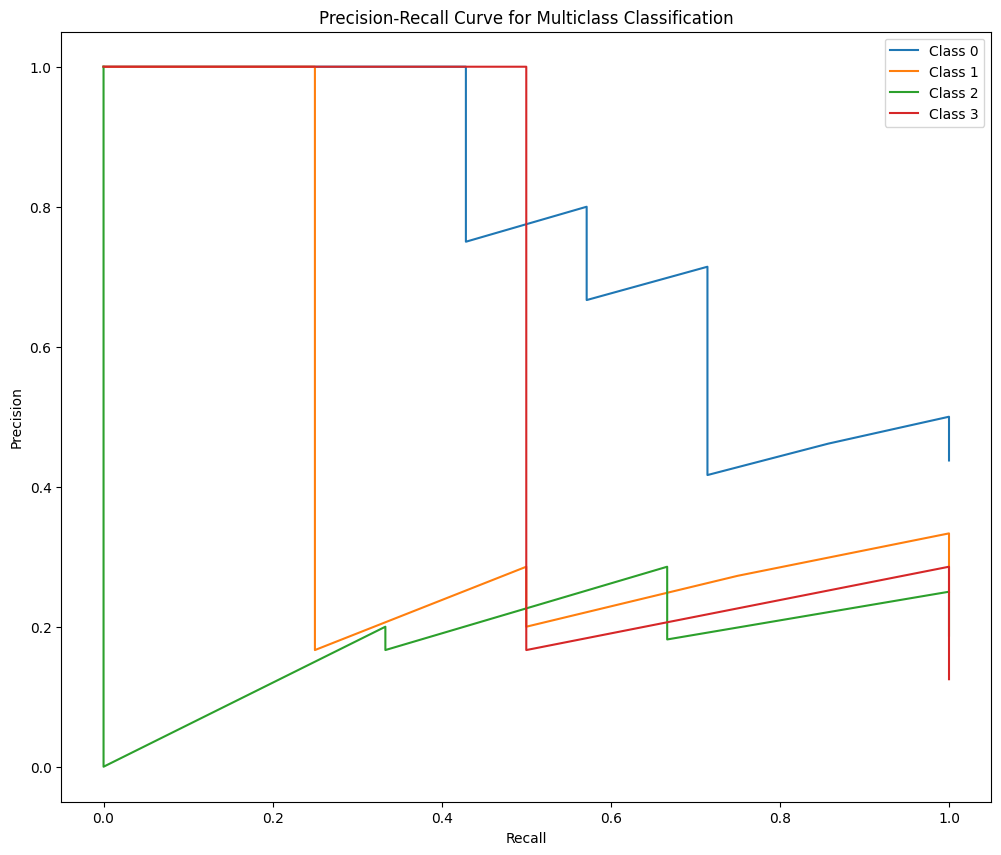

In [162]:
plot_multiclass_prc(lr_cv, scaled_X_test, y_test, n_classes=4, figsize=(12, 10))

**ROC CURVE**

In [163]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curve')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='label %i (area = %0.2f)' % (i, roc_auc[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

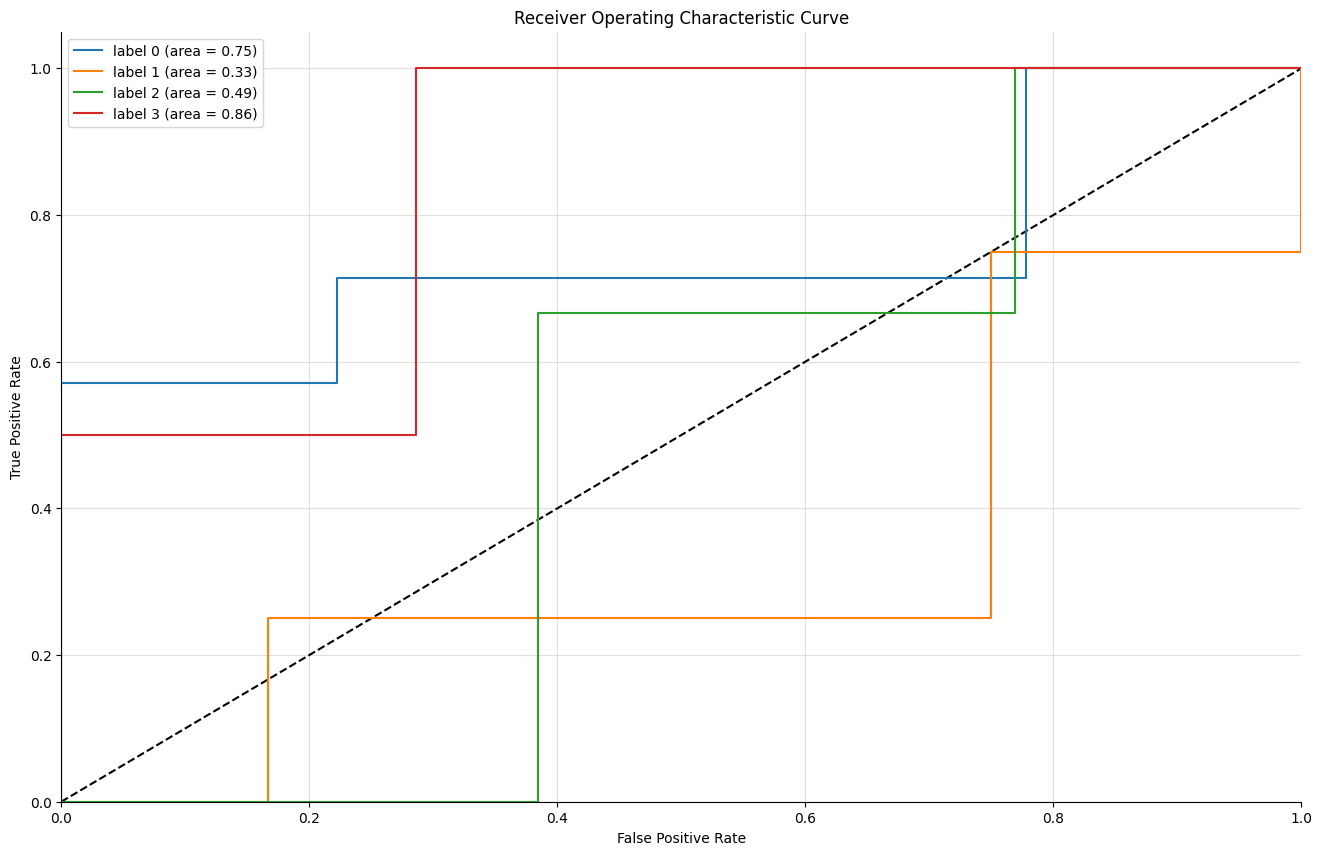

In [164]:
plot_multiclass_roc(lr_cv, scaled_X_test, y_test, n_classes=4, figsize=(16, 10))